## Import Libraries

In [2]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd

/home/glennrd/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Import data

In [3]:
adata = sc.read_h5ad('/home/glennrd/Documents/Research_Project/RNA-seq_Analysis/Data/1_GSE147319_adata_processed.h5ad')
adata_raw = sc.read_h5ad('/home/glennrd/Documents/Research_Project/RNA-seq_Analysis/Data/2_GSE147319_adata_raw.h5ad')

## Data exploration

In [4]:
# Investigate shape of sparse matrix (adata) #N.B. zeroes do not get displayed by printing
print(adata.X.shape)
print(adata.X[0:5,0:1])
# Investigate shape of sparse matrix (adata_raw)
print(adata_raw.X.shape)
print(adata_raw.X[0:5,0:8])

# Investigate shape of obs and var
print(adata_raw.obs.shape)
print(adata_raw.X.shape)
print(adata_raw.obs.head())
print(adata_raw.var.head())




(27687, 15723)
  (0, 0)	1.3862943649291992
  (1, 0)	1.0986123085021973
  (2, 0)	0.6931471824645996
  (3, 0)	2.079441547393799
  (4, 0)	0.6931471824645996
(28456, 27998)
  (0, 7)	3.0
  (1, 7)	2.0
  (2, 7)	1.0
  (3, 7)	7.0
  (4, 7)	1.0
(28456, 5)
(28456, 27998)
                         percent_mito  percent_ribo  n_counts  n_genes sample
index                                                                        
AAACCTGAGAGTAAGG-1-CD_1      0.063233      0.368494   18155.0     3799   CD_1
AAACCTGAGGTGATTA-1-CD_1      0.028060      0.322381   16465.0     3403   CD_1
AAACCTGCAAGTAGTA-1-CD_1      0.016215      0.178361   10361.0     3443   CD_1
AAACCTGCACACCGAC-1-CD_1      0.031618      0.285004   24954.0     4623   CD_1
AAACCTGGTACACCGC-1-CD_1      0.041818      0.397482    4687.0     1647   CD_1
             mean  frac_zeros
index                        
Xkr4     0.000633    0.999367
Gm1992   0.000000    1.000000
Gm37381  0.000000    1.000000
Rp1      0.000000    1.000000
Rp1-1    0.000

## Data Preparation Overview (Completed by Authors)

### Quality Metrics Creation
For both observations (obs) and variables (var), the following quality metrics were established:

- **Observations (obs):**
  - `index`: Cell name
  - `percent_mito`: Percentage of mitochondrial gene counts
  - `percent_ribo`: Percentage of ribosomal gene counts
  - `n_counts`: Total count of expressions
  - `n_genes`: Number of genes
  - `sample`: Sample identifier

- **Variables (var):**
  - `index`: Gene name
  - `mean`: Average count
  - `frac_zeroes`: Fraction of zero counts

### Quality-based Filtering
Cells were filtered out based on the following criteria:
- Cells with fewer than 1000 total genes.
- Cells with a total count of expressions less than a predefined minimum (`countmin`).

### Data cleaning
1. Gene names in AnnData objects are made unique by appending suffixes to duplicates using the var_names_make_unique() method.  
2. Each AnnData object representing different sample groups (adata_CD_1_filt, adata_CD_2_filt, adata_CD_3_filt, adata_HFD_1_filt, adata_HFD_2_filt, adata_HFD_3_filt) is concatenated into a single AnnData object adata_all, using 'sample' as the batch key and specifying the batch categories.  
3. Two columns, diet and batch, are added to the adata_all object, derived from parsing the sample identifiers to facilitate grouped analyses and visualizations.  
4. Empty droplets are subsetted into their own anndata object (cells with low gene counts 1-200)
5. Ambient genes are identified as genes that appear in more than 1% of empty droplets (background noise genes)

# Load raw count matrix provided on GEO

In [5]:
adata_all = sc.read('../2_GSE147319_adata_raw.h5ad')

## Gene filter

In [6]:
def qc_metrics(adata):
    '''
    creates qc metrics for each cell (obs) and for each gene (var)
    '''
    # mean expression per gene
    adata.var["mean"] = adata.X.mean(axis=0).T
    # fraction of 0s per genes
    adata.var["frac_zeros"] = (adata.X.shape[0] - (adata.X > 0).sum(axis=0).T) / adata.X.shape[0]
    
    # for each cell compute fraction of counts in mito genes vs. all genes
    mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
    mt_gene_index = np.where(mito_genes)[0]
    adata.obs['percent_mito'] = adata[:, mt_gene_index].X.sum(axis=1) / adata.X.sum(axis=1)
    # for each cell compute fraction of counts in ribosomal genes vs. all genes
    ribo_genes = [name for name in adata.var_names if name.startswith('Rp')]
    ribo_gene_index = np.where(ribo_genes)[0]
    adata.obs['percent_ribo'] = adata[:, ribo_gene_index].X.sum(axis=1) / adata.X.sum(axis=1)

    # total counts and genes per cell
    adata.obs['n_counts'] = np.sum(adata.X, axis=1).A1
    adata.obs['n_genes'] = np.sum(adata.X > 0, axis=1).A1
    print(len(adata.obs_names))
    
    return(adata)

In [7]:
sc.pp.filter_genes(adata_all,min_cells=20)
adata_all = qc_metrics(adata_all)

28456


## Scale

## Log Transform

In [8]:
adata_all_log = sc.pp.log1p(adata_all,copy=True)

## Batch correction

load _**adapted**_ combat.py file provided here https://github.com/brentp/combat.py

In [9]:
import sys
sys.path.append('/home/glennrd/Documents/Research_Project/RNA-seq_Analysis/Data/Jupyter_Notebooks')
import combat
from scipy.sparse import csr_matrix

# densify count matrix and get batch ID
data = pd.DataFrame(adata_all_log.X.todense())
batch = pd.Series(adata_all_log.obs['sample'])
batch = batch.reset_index()

# get index of 0s before correction
ix_zero = data==0

data_cor = combat.combat(data.T, batch['sample'])
del data

# reset 0s
data_cor.T[ix_zero]=0

# convert to sparse matrix
adata_all_log_cor = adata_all_log.copy()
adata_all_log_cor.X = csr_matrix(data_cor.T)
del data_cor

## Feature Selection

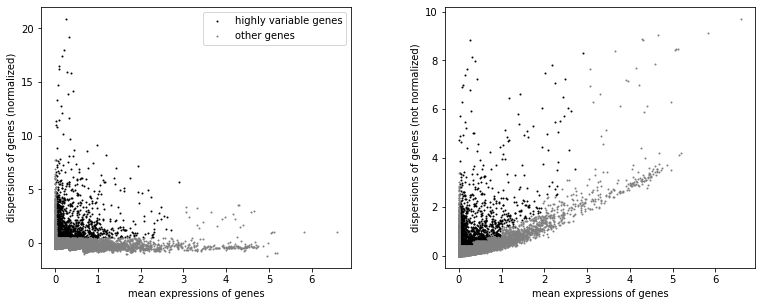

In [10]:
# get and subset to highly variable genes
sc.pp.highly_variable_genes(adata_all_log, min_mean=0.0125, min_disp=0.5)
sc.pl.highly_variable_genes(adata_all_log)
adata_all_log_cor_hvg = adata_all_log[:, adata_all_log.var['highly_variable']].copy()

## Dimensionality Reduction

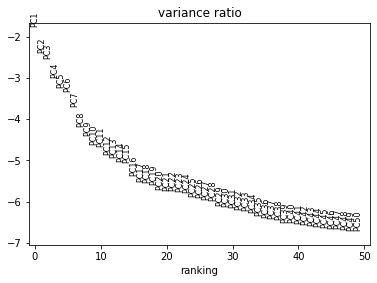

/home/glennrd/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
2024-06-18 16:06:52.386847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# PCA
sc.pp.pca(adata_all_log_cor_hvg)
sc.pl.pca_variance_ratio(adata_all_log_cor_hvg, n_pcs=50, log=True)
# kNN
sc.pp.neighbors(adata_all_log_cor_hvg, n_neighbors=25, n_pcs=50)

## Clustering (Louvain. Later will switch to Leiden) 

In [12]:
# Clustering
sc.tl.leiden(adata_all_log_cor_hvg, resolution=0.3, flavor="igraph", n_iterations=2)

## Compute & plot UMAP

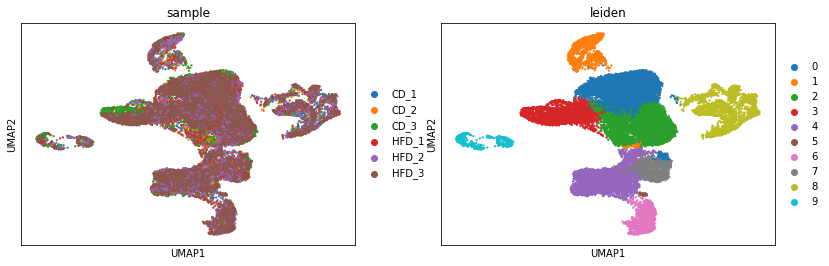

In [13]:
# UMAP (embeds neighbourhood graph to two dimensions)
sc.tl.umap(adata_all_log_cor_hvg)
# Plot UMAP
sc.pl.umap(adata_all_log_cor_hvg, color=['sample', 'leiden'],size=20)

## Identify Lymphocyte Cluster For Exclusion

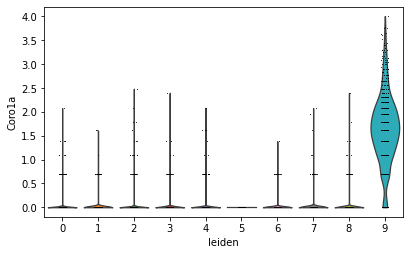

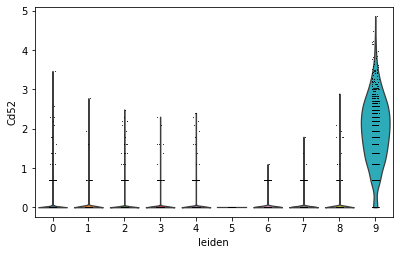

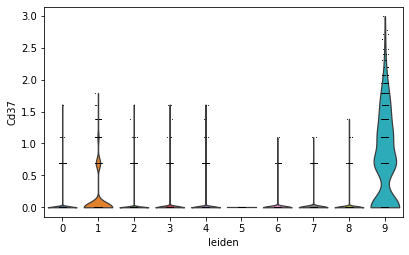

In [15]:
# lymphocyte markers
sc.pl.violin(adata_all_log_cor_hvg, keys='Coro1a', groupby='leiden')
sc.pl.violin(adata_all_log_cor_hvg, keys='Cd52', groupby='leiden')
sc.pl.violin(adata_all_log_cor_hvg, keys='Cd37', groupby='leiden')

In [17]:
lym_cells = np.isin(adata_all_log_cor_hvg.obs['leiden'], ['9'])
print(np.sum(lym_cells))
adata_all_log_cor_hvg = adata_all_log_cor_hvg[~lym_cells,:].copy()

770


In [22]:
sc.write('adata_corrected.h5', adata_all_log_cor_hvg)

## QC Summary

In [19]:
adata_all.obs[['n_counts', 'n_genes', 'sample']].groupby(['sample']).median()

,n_counts,n_genes
sample,,
CD_1,16681.0,3496.0
CD_2,15819.0,3385.0
CD_3,18378.0,3714.5
HFD_1,19687.0,3816.0
HFD_2,16164.0,3204.0
HFD_3,16975.5,3492.0


In [21]:
sc.set_figure_params(vector_friendly=True, color_map='RdBu_r', dpi_save=300)
sc.pl.umap(adata_all, color=['groups_named_prog4'], size=10)
sc.pl.umap(adata_all, size=10, palette='lightgrey')

KeyError: "Could not find 'umap' or 'X_umap' in .obsm"